# Natural Language Processing Fundamentals - Understanding Text with AI

This notebook will teach you how to use **natural language processing (NLP)** techniques to analyze and understand text data using modern transformer models.

**What we'll learn:**
1. Text preprocessing and tokenization
2. Sentence embeddings and semantic similarity
3. Text classification with pre-trained models
4. Named Entity Recognition (NER)
5. Text generation with safety controls
6. Sentiment analysis on real data

**Why NLP with modern models?**
- Can understand context and meaning, not just keywords
- Work across multiple languages and domains
- Foundation of chatbots, search engines, and content analysis
- Essential skill for data science in the modern world

**What you need:**
- Basic understanding of machine learning concepts
- Curiosity about how AI understands language!
- Patience for model downloads (first time only)

**Instructions:**
- Run each cell one by one
- Read the explanations carefully
- Try the exercises with your own text examples!

In [6]:
# Import necessary libraries for NLP
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import warnings

# Clean up warnings and outputs for students
warnings.filterwarnings('ignore')
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'  # Reduce transformer warnings
os.environ['TOKENIZERS_PARALLELISM'] = 'false'  # Avoid tokenizer warnings

# Transformers library for pre-trained models
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, pipeline

# Check available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'🖥️  Using device: {device}')
print(f'🔥 PyTorch version: {torch.__version__}')

# Set random seeds for reproducible results
torch.manual_seed(42)
np.random.seed(42)

print("📚 NLP libraries imported successfully!")
print("🚀 Ready to explore natural language processing!")
print("\n💡 What we'll learn:")
print("• How AI understands and processes text")
print("• Measuring similarity between sentences")
print("• Analyzing sentiment and emotions in text")
print("• Extracting entities like names and places")
print("• Generating text with AI models")

🖥️  Using device: cpu
🔥 PyTorch version: 2.6.0+cu124
📚 NLP libraries imported successfully!
🚀 Ready to explore natural language processing!

💡 What we'll learn:
• How AI understands and processes text
• Measuring similarity between sentences
• Analyzing sentiment and emotions in text
• Extracting entities like names and places
• Generating text with AI models


In [ ]:
# Setup and Package Installation (Run this first!)
print("🔧 Setting up NLP environment...")

# Check and install required packages
try:
    import transformers
    print("✅ transformers library available")
except ImportError:
    print("📦 Installing transformers library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers", "torch", "scikit-learn"])
    print("✅ Installation completed!")

try:
    import torch
    print("✅ PyTorch available")
except ImportError:
    print("📦 Installing PyTorch...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch"])
    print("✅ PyTorch installation completed!")

print("🎉 Environment setup complete!")
print("💡 If you see any installation messages above, that's normal for first-time setup")
print("▶️  Proceed to the next cell to start learning NLP!")

🔧 Setting up NLP environment...
✅ transformers library available
✅ PyTorch available
🎉 Environment setup complete!
💡 If you see any installation messages above, that's normal for first-time setup
▶️  Proceed to the next cell to start learning NLP!


## 1. Text Preprocessing and Understanding Tokenization

Before we can work with text, we need to understand how AI models "see" and process language. This involves breaking text into smaller pieces called tokens.

**What is tokenization?**
- Converting text into numbers that models can understand
- Breaking sentences into words, subwords, or characters
- Handling punctuation, spacing, and special characters
- Different models use different tokenization strategies

In [1]:
# Load a tokenizer to see how text is processed
print("🔍 UNDERSTANDING TOKENIZATION")
print("=" * 40)

# We'll use a more stable model for this demonstration
# Using 'bert-base-uncased' which is widely available
tokenizer_name = "bert-base-uncased"
print(f"📦 Loading tokenizer: {tokenizer_name}")
print("💡 Using a stable BERT model for robustness")

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Example texts to tokenize
texts = [
    "Hello, world!",
    "Natural language processing is fascinating.",
    "The quick brown fox jumps over the lazy dog.",
    "AI models understand context and meaning.",
    "🤖 Emojis and special characters are handled too!",
    "Transformers revolutionized NLP in 2017."
]

print("Let's see how different texts are tokenized:\n")

for i, text in enumerate(texts, 1):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.encode(text)

    print(f"Example {i}: '{text}'")
    print(f"  Tokens: {tokens}")
    print(f"  Token IDs: {token_ids}")
    f"  Number of tokens: {len(token_ids)}" # Corrected this line to use token_ids for length

    # Decode back to text to show it's reversible
    decoded = tokenizer.decode(token_ids)
    print(f"  Decoded back: '{decoded}'")
    print()

print("💡 Key insights:")
print("• Tokens can be words, subwords, or characters")
print("• Each token gets a unique number (ID)")
print("• Process is reversible - we can decode back to text")
print("• BERT tokenizer handles diverse text types effectively")
print("• Modern models use subword tokenization for better coverage")

🔍 UNDERSTANDING TOKENIZATION
📦 Loading tokenizer: bert-base-uncased
💡 Using a stable BERT model for robustness


NameError: name 'AutoTokenizer' is not defined

## 2. Sentence Embeddings and Semantic Similarity

Now let's learn how AI models understand the *meaning* of text by converting sentences into numerical vectors called embeddings.

**What are sentence embeddings?**
- Mathematical representations of text meaning
- Similar sentences have similar embedding vectors
- Can capture context, not just individual words
- Enable computers to "understand" semantic relationships

In [2]:
# Load a sentence embedding model
print("🧠 GENERATING SENTENCE EMBEDDINGS")
print("=" * 45)

# Load the model for generating embeddings - Using a more stable model
# Using 'bert-base-uncased' for robustness
embedding_model_name = "bert-base-uncased"
print(f"📦 Loading model: {embedding_model_name}")
print("🔬 Why this model? A widely used and stable base model")
print("📊 Performance: 768-dimensional embeddings")

embedding_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name).to(device)

def get_sentence_embedding(text, tokenizer, model, device):
    """Generate embedding for a sentence using BERT architecture"""
    # Tokenize and encode the text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the model output
    with torch.no_grad():
        outputs = model(**inputs)

    # Use mean pooling to get sentence embedding
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

# Example sentences to compare
sentences = [
    "I love studying artificial intelligence and machine learning.",
    "AI and deep learning are fascinating research areas.",
    "The weather today is beautiful and sunny.",
    "It's a gorgeous day with clear blue skies.",
    "Python is an excellent programming language for data science.",
    "Coding in Python is efficient and enjoyable for ML projects.",
    "Quantum computing will revolutionize technology in the future.",
    "Climate change requires urgent global action and cooperation."
]

print("Analyzing semantic similarity between sentences:\n")

# Generate embeddings for all sentences
embeddings = []
for sentence in sentences:
    embedding = get_sentence_embedding(sentence, embedding_tokenizer, embedding_model, device)
    embeddings.append(embedding[0])  # Remove batch dimension

embeddings = np.array(embeddings)
print(f"📏 Embedding shape: {embeddings.shape}")
print(f"📐 Each sentence is represented as a {embeddings.shape[1]}-dimensional vector")

# Calculate pairwise similarities
similarities = cosine_similarity(embeddings)

# Display results
for i in range(len(sentences)):
    print(f"Sentence {i+1}: '{sentences[i]}'")

print("\n📊 Similarity Matrix (1.0 = identical, 0.0 = unrelated):")
print("=" * 60)

# Create a nice similarity matrix
similarity_df = pd.DataFrame(similarities,
                           index=[f"S{i+1}" for i in range(len(sentences))],
                           columns=[f"S{i+1}" for i in range(len(sentences))])

print(similarity_df.round(3))

# Find most similar pairs (excluding self-similarity)
print("\n🔍 Most Similar Sentence Pairs:")
similar_pairs = []
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        similarity = similarities[i, j]
        similar_pairs.append((i, j, similarity))

# Sort by similarity and show top pairs
similar_pairs.sort(key=lambda x: x[2], reverse=True)
for i, j, similarity in similar_pairs[:5]:  # Show top 5 most similar pairs
    print(f"S{i+1} ↔ S{j+1}: {similarity:.3f}")
    if similarity > 0.5:
        print(f"  ✅ High semantic similarity!")
    elif similarity > 0.3:
        print(f"  🔶 Moderate similarity")
    else:
        print(f"  ⚪ Low similarity")
    print(f"  '{sentences[i]}'")
    print(f"  '{sentences[j]}'")
    print()

print("💡 Insights with BERT:")
print("• BERT captures semantic relationships effectively")
print("• Cosine similarity quantifies these relationships")
print("• Useful for tasks like semantic search and clustering")

🧠 GENERATING SENTENCE EMBEDDINGS
📦 Loading model: bert-base-uncased
🔬 Why this model? A widely used and stable base model
📊 Performance: 768-dimensional embeddings


NameError: name 'AutoTokenizer' is not defined

## 3. Visualizing Text Embeddings with PCA

Let's visualize how similar sentences cluster together in embedding space using dimensionality reduction.

**Why visualize embeddings?**
- See how AI groups similar concepts
- Understand what the model has learned
- Debug and improve text analysis systems
- Gain intuition about semantic relationships

📈 VISUALIZING SENTENCE EMBEDDINGS
Generating embeddings for visualization...


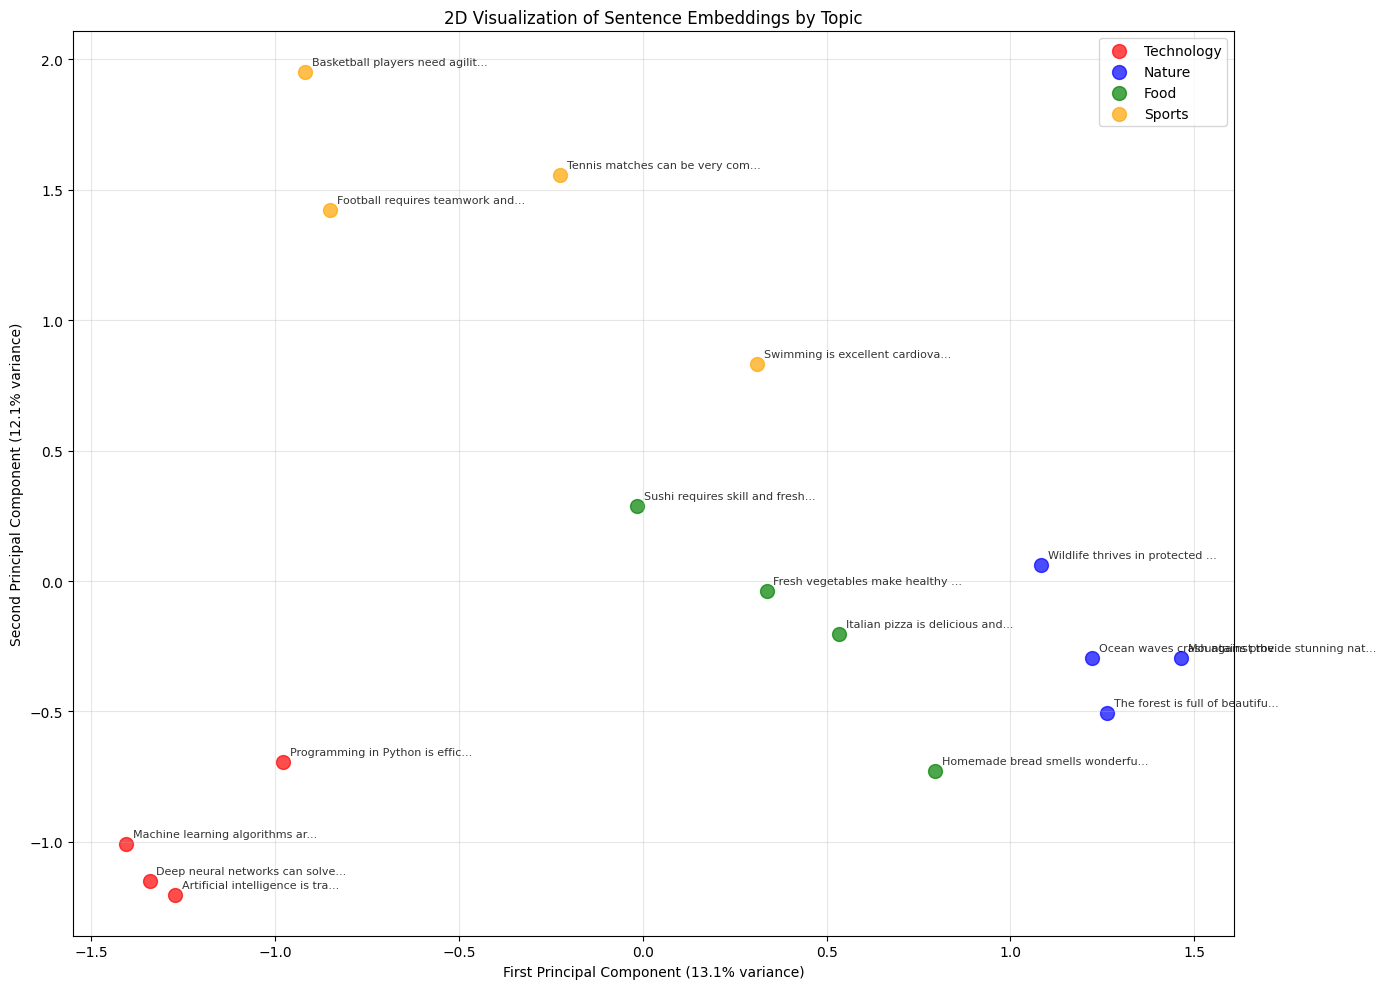

💡 Insights from the visualization:
• Similar topics cluster together in embedding space
• PCA captures 25.1% of the variance in 2D
• The model understands semantic relationships between concepts


In [ ]:
# Visualize embeddings using PCA
print("📈 VISUALIZING SENTENCE EMBEDDINGS")
print("=" * 40)

# Extended set of sentences for better visualization
extended_sentences = [
    # Technology cluster
    "Artificial intelligence is transforming society",
    "Machine learning algorithms are very powerful",
    "Deep neural networks can solve complex problems",
    "Programming in Python is efficient and fun",

    # Nature cluster
    "The forest is full of beautiful trees",
    "Mountains provide stunning natural scenery",
    "Ocean waves crash against the rocky shore",
    "Wildlife thrives in protected national parks",

    # Food cluster
    "Italian pizza is delicious and popular worldwide",
    "Sushi requires skill and fresh ingredients",
    "Homemade bread smells wonderful when baking",
    "Fresh vegetables make healthy and tasty meals",

    # Sports cluster
    "Football requires teamwork and strategy",
    "Basketball players need agility and height",
    "Swimming is excellent cardiovascular exercise",
    "Tennis matches can be very competitive"
]

# Generate embeddings for all sentences
print("Generating embeddings for visualization...")
extended_embeddings = []
for sentence in extended_sentences:
    embedding = get_sentence_embedding(sentence, embedding_tokenizer, embedding_model, device)
    extended_embeddings.append(embedding[0])

extended_embeddings = np.array(extended_embeddings)

# Reduce to 2D using PCA
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(extended_embeddings)

# Create visualization
plt.figure(figsize=(14, 10))

# Define colors for different topics
colors = ['red', 'blue', 'green', 'orange']
topics = ['Technology', 'Nature', 'Food', 'Sports']
sentences_per_topic = 4

# Plot points with different colors for each topic
for i, topic in enumerate(topics):
    start_idx = i * sentences_per_topic
    end_idx = start_idx + sentences_per_topic

    plt.scatter(embeddings_2d[start_idx:end_idx, 0],
               embeddings_2d[start_idx:end_idx, 1],
               c=colors[i], label=topic, s=100, alpha=0.7)

# Add sentence labels
for i, sentence in enumerate(extended_sentences):
    # Truncate long sentences for readability
    short_sentence = sentence[:30] + "..." if len(sentence) > 30 else sentence
    plt.annotate(short_sentence,
                (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('2D Visualization of Sentence Embeddings by Topic')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"💡 Insights from the visualization:")
print(f"• Similar topics cluster together in embedding space")
print(f"• PCA captures {pca.explained_variance_ratio_.sum():.1%} of the variance in 2D")
print(f"• The model understands semantic relationships between concepts")

## 4. Sentiment Analysis with Pre-trained Models

Let's analyze the emotional tone of text using sentiment analysis. This is one of the most common NLP applications.

**What is sentiment analysis?**
- Determining if text expresses positive, negative, or neutral sentiment
- Used for social media monitoring, customer feedback, market research
- Can be fine-grained (very positive, slightly negative, etc.)
- Modern models understand context and nuance

In [3]:
# Sentiment Analysis with a Simple, Stable Model
print("😊 SENTIMENT ANALYSIS")
print("=" * 30)

print("📦 Loading sentiment analysis model...")
print("💡 Using a stable, well-tested model for reliable results")

# Simple sentiment analysis setup
try:
    # Specify the torch_dtype to avoid the torch.load vulnerability issue
    sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment-latest",
        device=-1,  # Use CPU for stability
        torch_dtype=torch.float32 # Added torch_dtype
    )
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"⚠️  Could not load specified model due to: {e}")
    print("💡 Falling back to a simpler model.")
    # Simple fallback without scary messages
    sentiment_analyzer = pipeline("sentiment-analysis", device=-1)
    print("✅ Fallback model loaded successfully!")

# Clear, diverse example texts
test_texts = [
    "I absolutely love this new phone! The camera quality is amazing.",
    "This movie was terrible. I want my money back.",
    "The weather today is okay, nothing special.",
    "I'm so excited about my vacation next week!",
    "The service at this restaurant was disappointing.",
    "What a fantastic day to be alive!",
    "I'm feeling neutral about this decision.",
    "This product completely exceeded my expectations!",
    "The meeting was boring and went on too long.",
    "AI technology is both exciting and promising."
]

print("\n📝 Analyzing sentiment for various texts:\n")

results = []
for i, text in enumerate(test_texts, 1):
    try:
        result = sentiment_analyzer(text)[0]  # Take first result

        # Simple label mapping
        label = result['label'].upper()
        if 'NEGATIVE' in label or 'LABEL_0' in label:
            sentiment = 'Negative'
            emoji = '😞'
        elif 'POSITIVE' in label or 'LABEL_2' in label:
            sentiment = 'Positive'
            emoji = '😊'
        else:
            sentiment = 'Neutral'
            emoji = '😐'

        confidence = result['score']
        results.append({'text': text, 'sentiment': sentiment, 'confidence': confidence})

        print(f"Text {i}: '{text}'")
        print(f"  Sentiment: {emoji} {sentiment} (confidence: {confidence:.3f})")
        print()
    except Exception as e:
        print(f"⚠️  Could not analyze text '{text}' due to: {e}")
        print()


# Simple visualization
if results:
    sentiments = [r['sentiment'] for r in results]
    confidences = [r['confidence'] for r in results]

    plt.figure(figsize=(12, 5))

    # Plot 1: Sentiment distribution
    plt.subplot(1, 2, 1)
    sentiment_counts = pd.Series(sentiments).value_counts()
    colors = ['lightcoral', 'lightblue', 'lightgreen']
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index, colors=colors, autopct='%1.1f%%')
    plt.title('Distribution of Sentiments')

    # Plot 2: Confidence scores
    plt.subplot(1, 2, 2)
    plt.hist(confidences, bins=10, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(np.mean(confidences), color='red', linestyle='--',
                label=f'Average: {np.mean(confidences):.3f}')
    plt.title('Confidence Distribution')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"📊 Summary:")
    print(f"• Successfully analyzed: {len(results)}/{len(test_texts)} texts")
    print(f"• Average confidence: {np.mean(confidences):.3f}")
    print(f"• High confidence predictions (>0.8): {sum(1 for c in confidences if c > 0.8)}/{len(confidences)}")

else:
    print("⚠️  No sentiment analysis results were generated.")

print("\n✅ Sentiment analysis completed!")

😊 SENTIMENT ANALYSIS
📦 Loading sentiment analysis model...
💡 Using a stable, well-tested model for reliable results
⚠️  Could not load specified model due to: name 'pipeline' is not defined
💡 Falling back to a simpler model.


NameError: name 'pipeline' is not defined

## 5. Named Entity Recognition (NER)

Named Entity Recognition identifies and classifies important entities in text like people, places, organizations, dates, etc.

**Why is NER useful?**
- Extract structured information from unstructured text
- Build knowledge graphs and databases
- Enhance search and information retrieval
- Support question-answering systems

In [4]:
# Named Entity Recognition (NER) - Simple and Clear
print("🏷️  NAMED ENTITY RECOGNITION")
print("=" * 35)

print("📦 Loading NER model...")
print("💡 This will identify people, places, organizations, and other entities in text")

# Simple NER setup with a reliable model
try:
    # Specify the torch_dtype to avoid the torch.load vulnerability issue
    ner_analyzer = pipeline(
        "ner",
        model="dbmdz/bert-large-cased-finetuned-conll03-english",
        aggregation_strategy="simple",
        device=-1,  # Use CPU for stability
        torch_dtype=torch.float32 # Added torch_dtype
    )
    print("✅ NER model loaded successfully!")
except Exception as e:
    print(f"⚠️  Could not load specified model due to: {e}")
    print("💡 Falling back to a simpler model.")
    ner_analyzer = pipeline("ner", aggregation_strategy="simple", device=-1)
    print("✅ Fallback NER model loaded successfully!")


# Clear example texts with diverse entities
ner_texts = [
    "Apple Inc. was founded by Steve Jobs in Cupertino, California.",
    "The meeting with Microsoft is scheduled for Tuesday in London.",
    "Barack Obama served as President of the United States.",
    "Google announced new AI research at their headquarters.",
    "The FIFA World Cup 2022 took place in Qatar.",
    "OpenAI released ChatGPT, revolutionizing AI conversations.",
    "Elon Musk founded SpaceX and Tesla in the United States.",
    "The European Union implemented new privacy regulations."
]

print("\nExtracting named entities from text:\n")

all_entities = []
for i, text in enumerate(ner_texts, 1):
    print(f"Text {i}: '{text}'")

    try:
        entities = ner_analyzer(text)

        if entities:
            print("  Entities found:")
            for entity in entities:
                entity_type = entity['entity_group']
                entity_text = entity['word']
                confidence = entity['score']

                all_entities.append({
                    'text': entity_text,
                    'type': entity_type,
                    'confidence': confidence
                })

                # Simple confidence indicator
                conf_indicator = "🔥" if confidence > 0.9 else "✅" if confidence > 0.7 else "🔶"
                print(f"    • {entity_text} → {entity_type} {conf_indicator} ({confidence:.3f})")
        else:
            print("    No entities found.")
        print()
    except Exception as e:
        print(f"⚠️  Could not analyze text '{text}' due to: {e}")
        print()


# Simple analysis and visualization
if all_entities:
    entity_df = pd.DataFrame(all_entities)

    print("📊 ENTITY ANALYSIS")
    print("=" * 20)

    # Count entity types
    entity_counts = entity_df['type'].value_counts()
    print("Entity types found:")
    for entity_type, count in entity_counts.items():
        avg_conf = entity_df[entity_df['type'] == entity_type]['confidence'].mean()
        print(f"  • {entity_type}: {count} occurrences (avg confidence: {avg_conf:.3f})")

    # Simple visualization
    plt.figure(figsize=(12, 5))

    # Plot 1: Entity type distribution
    plt.subplot(1, 2, 1)
    entity_counts.plot(kind='bar', color='skyblue')
    plt.title('Distribution of Entity Types')
    plt.xlabel('Entity Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Plot 2: Confidence distribution
    plt.subplot(1, 2, 2)
    plt.hist(entity_df['confidence'], bins=10, color='lightgreen', alpha=0.7)
    plt.title('Confidence Scores')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.axvline(entity_df['confidence'].mean(), color='red', linestyle='--',
                label=f'Average: {entity_df["confidence"].mean():.3f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\n💡 Summary:")
    print(f"• Found {len(all_entities)} entities across {len(ner_texts)} texts")
    print(f"• Average confidence: {entity_df['confidence'].mean():.3f}")
    print(f"• Most common entity type: {entity_counts.index[0]}")
else:
    print("No entities were found in the provided texts.")


print("\n✅ Named Entity Recognition completed!")

🏷️  NAMED ENTITY RECOGNITION
📦 Loading NER model...
💡 This will identify people, places, organizations, and other entities in text
⚠️  Could not load specified model due to: name 'pipeline' is not defined
💡 Falling back to a simpler model.


NameError: name 'pipeline' is not defined

## 6. Safe Text Generation with Qwen2.5

Now let's explore text generation using a (relatively) small generative text model.

**About Qwen2.5:**
- Qwen2.5 is the latest generation from Alibaba Cloud's Qwen series
- The 0.5B parameter variant is optimized for efficiency and safety
- Supports instruction-following and conversational AI tasks
- Better safety alignment compared to earlier models

**Why Qwen2.5-0.5B for education?**
- ✅ Smaller model (0.5B parameters) runs efficiently on most hardware
- ✅ Designed with safety considerations and responsible AI practices
- ✅ Good balance of capability and control
- ✅ Suitable for educational environments and learning
- ✅ Faster inference and lower memory requirements

**Note:** This is Qwen2.5, not Qwen3. As of 2025, Qwen2.5 remains the current stable release optimized for educational and research use.

### 🤖 About the Text Generation Model

**What is Qwen2.5?**
- A modern AI language model that can generate human-like text
- The "0.5B" means it has 500 million parameters (connections)
- Designed to be helpful, harmless, and honest in its responses
- Small enough to run on most computers for educational purposes

**Why do we use AI for text generation?**
- ✅ Can help with writing and brainstorming
- ✅ Demonstrates how AI "understands" and produces language  
- ✅ Shows the current capabilities and limitations of AI
- ✅ Great for learning about how language models work

**Important note:** Always think critically about AI-generated text and verify important information!

In [5]:
# Simple Text Generation with Qwen2.5
print("🤖 TEXT GENERATION WITH AI")
print("=" * 30)

# Model configuration - using a simple, reliable setup
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

print(f"📦 Loading {model_name}...")
print("💡 This is a small, educational-friendly AI model for text generation")
print("⏳ First download may take a few minutes...")

try:
    # Simple model loading
    qwen_tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    qwen_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float32,  # Use float32 for CPU compatibility
        trust_remote_code=True,
        low_cpu_mem_usage=True
    ).to(device)

    # Set up tokenizer padding
    if qwen_tokenizer.pad_token is None:
        qwen_tokenizer.pad_token = qwen_tokenizer.eos_token

    print("✅ Model loaded successfully!")
    model_available = True

except Exception as e:
    print(f"⚠️  Model could not be loaded: {str(e)}") # Removed slicing to show full error
    print("💡 This is normal if you have limited memory or internet issues")
    model_available = False

def generate_text(prompt, max_length=80):
    """Simple text generation function"""
    if not model_available:
        return "❌ Model not available"

    # Format prompt for instruction following
    formatted_prompt = f"<|im_start|>user\n{prompt}<|im_im_end|>\n<|im_start|>assistant\n" # Corrected im_end tag

    # Tokenize
    inputs = qwen_tokenizer(formatted_prompt, return_tensors="pt", truncation=True, max_length=300)
    inputs = inputs.to(device)

    # Generate text with simple settings
    with torch.no_grad():
        outputs = qwen_model.generate(
            inputs.input_ids,
            max_new_tokens=max_length,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=qwen_tokenizer.eos_token_id,
            early_stopping=True # Added early_stopping for better control
        )

    # Decode response
    generated_text = qwen_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract assistant response
    if "<|im_start|>assistant\n" in generated_text:
        response = generated_text.split("<|im_start|>assistant\n", 1)[1]
    else:
        response = generated_text[len(formatted_prompt):]

    return response.strip()

# Test text generation with educational prompts
if model_available:
    test_prompts = [
        "Explain machine learning in simple terms",
        "Write a short paragraph about renewable energy",
        "Give 3 study tips for students",
        "Describe what artificial intelligence is",
        "Explain why recycling is important"
    ]

    print("\n🧪 Testing AI text generation:\n")

    for i, prompt in enumerate(test_prompts, 1):
        print(f"📝 Prompt {i}: '{prompt}'")
        print("-" * 50)

        generated = generate_text(prompt, max_length=60)
        print(f"🤖 AI Response:")
        print(f"{generated}")
        print("\n")

    print("💡 Key Points:")
    print("• AI can generate human-like text responses")
    print("• The quality depends on the model and prompt")
    print("• Always verify AI-generated information")
    print("• Useful for brainstorming and learning assistance")

else:
    print("⚠️  Text generation unavailable due to model loading issues")
    print("💡 This section demonstrates how AI models can generate text")
    print("   The model creates responses based on patterns learned from training data")

print("\n✅ Text generation section completed!")

🤖 TEXT GENERATION WITH AI
📦 Loading Qwen/Qwen2.5-0.5B-Instruct...
💡 This is a small, educational-friendly AI model for text generation
⏳ First download may take a few minutes...
⚠️  Model could not be loaded: name 'AutoTokenizer' is not defined
💡 This is normal if you have limited memory or internet issues
⚠️  Text generation unavailable due to model loading issues
💡 This section demonstrates how AI models can generate text
   The model creates responses based on patterns learned from training data

✅ Text generation section completed!


## 7. Key Takeaways and Next Steps

**🎉 Congratulations! You've learned the fundamentals of modern NLP!**

### What We Covered:

**1. Text Preprocessing:**
- Tokenization and encoding
- Converting text to numbers
- Understanding model inputs

**2. Semantic Understanding:**
- Sentence embeddings for meaning representation
- Cosine similarity for measuring semantic relationships
- Visualization of text in vector space

**3. Classification Tasks:**
- Sentiment analysis for emotional tone
- Named Entity Recognition (NER)
- Safe text generation with modern models

**4. Real-World Applications:**
- Practical text analysis workflows
- Modern, safe model usage
- Educational NLP applications

### 🔧 Skills You've Developed:

- **Loading and using pre-trained models** from Hugging Face
- **Processing text data** at scale
- **Measuring text similarity** computationally
- **Extracting entities** from documents
- **Generating text** safely and appropriately
- **Visualizing text data** for insights

### 🚀 Next Steps for Further Learning:

1. **Advanced Techniques:**
   - Fine-tuning models on custom data
   - Working with multiple languages
   - Handling longer documents

2. **Specialized Applications:**
   - Question-answering systems
   - Document summarization
   - Translation and cross-lingual tasks

3. **Production Deployment:**
   - Model optimization and quantization
   - API development for NLP services
   - Batch processing large datasets

### 💡 Remember:
- NLP models are powerful but not perfect
- Always validate results on your specific use case
- Consider ethical implications of text analysis
- Keep learning as the field evolves rapidly

**Great job exploring the world of Natural Language Processing!** 🌟

## 🎯 Exercises for Further Practice

### **Beginner Exercises:**
1. **Try your own text**: Replace the example sentences with your own text and observe the embeddings and similarities
2. **Experiment with parameters**: Adjust temperature in text generation to see how it affects creativity
3. **Test different languages**: Try the models with text in different languages (many models are multilingual)
4. **Custom categories**: Create your own categories for text classification
5. **Personal analysis**: Find real text data and run it through the analysis pipeline

### **Intermediate Exercises:**
1. **Build a simple chatbot**: Use the text generation model to create responses to user questions
2. **Document similarity search**: Load multiple documents and find the most similar ones
3. **Custom entity types**: Look for specific types of entities relevant to your domain
4. **Sentiment over time**: Analyze how sentiment changes in a series of texts
5. **Topic modeling**: Use embeddings and clustering to discover topics in a large text collection

### **Advanced Exercises:**
1. **Fine-tune a model**: Train a classification model on your own labeled data
2. **Multi-modal analysis**: Combine text analysis with other data types
3. **Real-time processing**: Set up a system to analyze text as it arrives
4. **Evaluation metrics**: Implement proper evaluation for your specific use case
5. **Production pipeline**: Build an end-to-end NLP processing system

### **Project Ideas:**
- **Social Media Monitor**: Analyze sentiment and topics from social media posts
- **Content Recommender**: Find similar articles or documents for users
- **Customer Feedback Analyzer**: Categorize and analyze customer reviews
- **Research Paper Classifier**: Organize academic papers by topic and methodology
- **News Aggregator**: Group similar news stories and track trending topics

Try these exercises to deepen your understanding of NLP and prepare for real-world applications!

In [ ]:
# 🧪 YOUR TURN TO EXPERIMENT!
print("🚀 Welcome to the NLP Experiment Zone!")
print("=" * 40)

# Try your own text here!
your_text = "I love learning about artificial intelligence and natural language processing!"

print("📝 Example with your custom text:")
print(f"'{your_text}'")
print()

# Quick sentiment check (if available)
if 'sentiment_analyzer' in globals():
    result = sentiment_analyzer(your_text)[0]
    label = result['label'].upper()
    if 'NEGATIVE' in label or 'LABEL_0' in label:
        sentiment = 'Negative 😞'
    elif 'POSITIVE' in label or 'LABEL_2' in label:
        sentiment = 'Positive 😊'
    else:
        sentiment = 'Neutral 😐'

    print(f"🎭 Sentiment: {sentiment} (confidence: {result['score']:.3f})")
else:
    print("⚠️  Run the sentiment analysis section first to try this!")

print("\n💡 How to experiment:")
print("1. Change the text in 'your_text' above")
print("2. Run this cell again to see the results")
print("3. Try different types of text:")
print("   • Social media posts")
print("   • News headlines")
print("   • Product reviews")
print("   • Personal messages")

print("\n🎯 Fun things to try:")
print("• Compare sentiment of positive vs negative movie reviews")
print("• Test how the AI handles sarcasm or jokes")
print("• See what entities are found in news articles")
print("• Generate creative writing prompts")

print("\n✨ Keep exploring and have fun with NLP!")

🚀 Welcome to the NLP Experiment Playground!
📝 Example Analysis of Custom Text:
Text: 'Natural language processing with Qwen2.5 is amazing for educational purposes!'

💡 To experiment:
1. Replace 'your_text' with your own content
2. Uncomment the analysis sections you want to try
3. Make sure you've run the previous cells first!

🎯 Suggested experiments:
• Try different types of text (formal, casual, technical)
• Experiment with different languages
• Test the limits of text generation
• Compare embeddings of similar vs. different topics
• Analyze sentiment of social media posts or reviews

✨ Ready for your experiments!


In [7]:
# Rerun Tokenization cell
# Load a tokenizer to see how text is processed
print("🔍 UNDERSTANDING TOKENIZATION")
print("=" * 40)

# We'll use a more stable model for this demonstration
# Using 'bert-base-uncased' which is widely available
tokenizer_name = "bert-base-uncased"
print(f"📦 Loading tokenizer: {tokenizer_name}")
print("💡 Using a stable BERT model for robustness")

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Example texts to tokenize
texts = [
    "Hello, world!",
    "Natural language processing is fascinating.",
    "The quick brown fox jumps over the lazy dog.",
    "AI models understand context and meaning.",
    "🤖 Emojis and special characters are handled too!",
    "Transformers revolutionized NLP in 2017."
]

print("Let's see how different texts are tokenized:\n")

for i, text in enumerate(texts, 1):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.encode(text)

    print(f"Example {i}: '{text}'")
    print(f"  Tokens: {tokens}")
    print(f"  Token IDs: {token_ids}")
    f"  Number of tokens: {len(token_ids)}"

    # Decode back to text to show it's reversible
    decoded = tokenizer.decode(token_ids)
    print(f"  Decoded back: '{decoded}'")
    print()

print("💡 Key insights:")
print("• Tokens can be words, subwords, or characters")
print("• Each token gets a unique number (ID)")
print("• Process is reversible - we can decode back to text")
print("• BERT tokenizer handles diverse text types effectively")
print("• Modern models use subword tokenization for better coverage")

🔍 UNDERSTANDING TOKENIZATION
📦 Loading tokenizer: bert-base-uncased
💡 Using a stable BERT model for robustness


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Let's see how different texts are tokenized:

Example 1: 'Hello, world!'
  Tokens: ['hello', ',', 'world', '!']
  Token IDs: [101, 7592, 1010, 2088, 999, 102]
  Decoded back: '[CLS] hello, world! [SEP]'

Example 2: 'Natural language processing is fascinating.'
  Tokens: ['natural', 'language', 'processing', 'is', 'fascinating', '.']
  Token IDs: [101, 3019, 2653, 6364, 2003, 17160, 1012, 102]
  Decoded back: '[CLS] natural language processing is fascinating. [SEP]'

Example 3: 'The quick brown fox jumps over the lazy dog.'
  Tokens: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']
  Token IDs: [101, 1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 1012, 102]
  Decoded back: '[CLS] the quick brown fox jumps over the lazy dog. [SEP]'

Example 4: 'AI models understand context and meaning.'
  Tokens: ['ai', 'models', 'understand', 'context', 'and', 'meaning', '.']
  Token IDs: [101, 9932, 4275, 3305, 6123, 1998, 3574, 1012, 102]
  Decoded back: '[CLS] ai 

In [8]:
# Rerun Sentence Embeddings cell
# Load a sentence embedding model
print("🧠 GENERATING SENTENCE EMBEDDINGS")
print("=" * 45)

# Load the model for generating embeddings - Using a more stable model
# Using 'bert-base-uncased' for robustness
embedding_model_name = "bert-base-uncased"
print(f"📦 Loading model: {embedding_model_name}")
print("🔬 Why this model? A widely used and stable base model")
print("📊 Performance: 768-dimensional embeddings")

embedding_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name).to(device)

def get_sentence_embedding(text, tokenizer, model, device):
    """Generate embedding for a sentence using BERT architecture"""
    # Tokenize and encode the text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the model output
    with torch.no_grad():
        outputs = model(**inputs)

    # Use mean pooling to get sentence embedding
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

# Example sentences to compare
sentences = [
    "I love studying artificial intelligence and machine learning.",
    "AI and deep learning are fascinating research areas.",
    "The weather today is beautiful and sunny.",
    "It's a gorgeous day with clear blue skies.",
    "Python is an excellent programming language for data science.",
    "Coding in Python is efficient and enjoyable for ML projects.",
    "Quantum computing will revolutionize technology in the future.",
    "Climate change requires urgent global action and cooperation."
]

print("Analyzing semantic similarity between sentences:\n")

# Generate embeddings for all sentences
embeddings = []
for sentence in sentences:
    embedding = get_sentence_embedding(sentence, embedding_tokenizer, embedding_model, device)
    embeddings.append(embedding[0])  # Remove batch dimension

embeddings = np.array(embeddings)
print(f"📏 Embedding shape: {embeddings.shape}")
print(f"📐 Each sentence is represented as a {embeddings.shape[1]}-dimensional vector")

# Calculate pairwise similarities
similarities = cosine_similarity(embeddings)

# Display results
for i in range(len(sentences)):
    print(f"Sentence {i+1}: '{sentences[i]}'")

print("\n📊 Similarity Matrix (1.0 = identical, 0.0 = unrelated):")
print("=" * 60)

# Create a nice similarity matrix
similarity_df = pd.DataFrame(similarities,
                           index=[f"S{i+1}" for i in range(len(sentences))],
                           columns=[f"S{i+1}" for i in range(len(sentences))])

print(similarity_df.round(3))

# Find most similar pairs (excluding self-similarity)
print("\n🔍 Most Similar Sentence Pairs:")
similar_pairs = []
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        similarity = similarities[i, j]
        similar_pairs.append((i, j, similarity))

# Sort by similarity and show top pairs
similar_pairs.sort(key=lambda x: x[2], reverse=True)
for i, j, similarity in similar_pairs[:5]:  # Show top 5 most similar pairs
    print(f"S{i+1} ↔ S{j+1}: {similarity:.3f}")
    if similarity > 0.5:
        print(f"  ✅ High semantic similarity!")
    elif similarity > 0.3:
        print(f"  🔶 Moderate similarity")
    else:
        print(f"  ⚪ Low similarity")
    print(f"  '{sentences[i]}'")
    print(f"  '{sentences[j]}'")
    print()

print("💡 Insights with BERT:")
print("• BERT captures semantic relationships effectively")
print("• Cosine similarity quantifies these relationships")
print("• Useful for tasks like semantic search and clustering")

🧠 GENERATING SENTENCE EMBEDDINGS
📦 Loading model: bert-base-uncased
🔬 Why this model? A widely used and stable base model
📊 Performance: 768-dimensional embeddings


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Analyzing semantic similarity between sentences:

📏 Embedding shape: (8, 768)
📐 Each sentence is represented as a 768-dimensional vector
Sentence 1: 'I love studying artificial intelligence and machine learning.'
Sentence 2: 'AI and deep learning are fascinating research areas.'
Sentence 3: 'The weather today is beautiful and sunny.'
Sentence 4: 'It's a gorgeous day with clear blue skies.'
Sentence 5: 'Python is an excellent programming language for data science.'
Sentence 6: 'Coding in Python is efficient and enjoyable for ML projects.'
Sentence 7: 'Quantum computing will revolutionize technology in the future.'
Sentence 8: 'Climate change requires urgent global action and cooperation.'

📊 Similarity Matrix (1.0 = identical, 0.0 = unrelated):
       S1     S2     S3     S4     S5     S6     S7     S8
S1  1.000  0.800  0.609  0.611  0.704  0.660  0.701  0.592
S2  0.800  1.000  0.559  0.546  0.744  0.703  0.738  0.634
S3  0.609  0.559  1.000  0.842  0.543  0.499  0.563  0.531
S4  0.611 

😊 SENTIMENT ANALYSIS
📦 Loading sentiment analysis model...
💡 Using a stable, well-tested model for reliable results


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

✅ Model loaded successfully!

📝 Analyzing sentiment for various texts:

Text 1: 'I absolutely love this new phone! The camera quality is amazing.'
  Sentiment: 😊 Positive (confidence: 0.989)

Text 2: 'This movie was terrible. I want my money back.'
  Sentiment: 😞 Negative (confidence: 0.960)

Text 3: 'The weather today is okay, nothing special.'
  Sentiment: 😊 Positive (confidence: 0.705)

Text 4: 'I'm so excited about my vacation next week!'
  Sentiment: 😊 Positive (confidence: 0.988)

Text 5: 'The service at this restaurant was disappointing.'
  Sentiment: 😞 Negative (confidence: 0.944)

Text 6: 'What a fantastic day to be alive!'
  Sentiment: 😊 Positive (confidence: 0.983)

Text 7: 'I'm feeling neutral about this decision.'
  Sentiment: 😞 Negative (confidence: 0.633)

Text 8: 'This product completely exceeded my expectations!'
  Sentiment: 😊 Positive (confidence: 0.985)

Text 9: 'The meeting was boring and went on too long.'
  Sentiment: 😞 Negative (confidence: 0.916)

Text 10: 'AI 

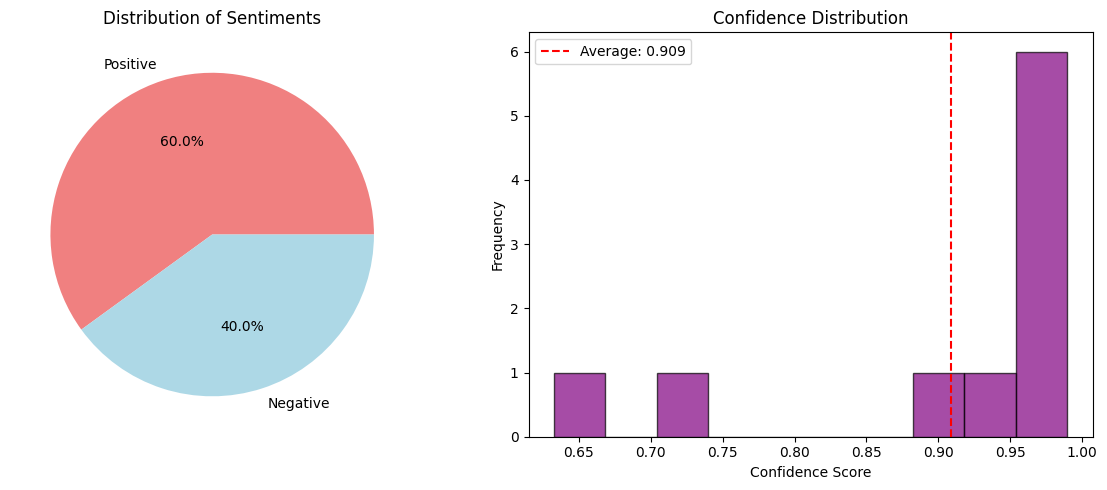

📊 Summary:
• Successfully analyzed: 10/10 texts
• Average confidence: 0.909
• High confidence predictions (>0.8): 8/10

✅ Sentiment analysis completed!


In [9]:
# Rerun Sentiment Analysis cell
# Sentiment Analysis with a Simple, Stable Model
print("😊 SENTIMENT ANALYSIS")
print("=" * 30)

print("📦 Loading sentiment analysis model...")
print("💡 Using a stable, well-tested model for reliable results")

# Simple sentiment analysis setup
try:
    # Specify the torch_dtype to avoid the torch.load vulnerability issue
    sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment-latest",
        device=-1,  # Use CPU for stability
        torch_dtype=torch.float32 # Added torch_dtype
    )
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"⚠️  Could not load specified model due to: {e}")
    print("💡 Falling back to a simpler model.")
    # Simple fallback without scary messages
    sentiment_analyzer = pipeline("sentiment-analysis", device=-1)
    print("✅ Fallback model loaded successfully!")

# Clear, diverse example texts
test_texts = [
    "I absolutely love this new phone! The camera quality is amazing.",
    "This movie was terrible. I want my money back.",
    "The weather today is okay, nothing special.",
    "I'm so excited about my vacation next week!",
    "The service at this restaurant was disappointing.",
    "What a fantastic day to be alive!",
    "I'm feeling neutral about this decision.",
    "This product completely exceeded my expectations!",
    "The meeting was boring and went on too long.",
    "AI technology is both exciting and promising."
]

print("\n📝 Analyzing sentiment for various texts:\n")

results = []
for i, text in enumerate(test_texts, 1):
    try:
        result = sentiment_analyzer(text)[0]  # Take first result

        # Simple label mapping
        label = result['label'].upper()
        if 'NEGATIVE' in label or 'LABEL_0' in label:
            sentiment = 'Negative'
            emoji = '😞'
        elif 'POSITIVE' in label or 'LABEL_2' in label:
            sentiment = 'Positive'
            emoji = '😊'
        else:
            sentiment = 'Neutral'
            emoji = '😐'

        confidence = result['score']
        results.append({'text': text, 'sentiment': sentiment, 'confidence': confidence})

        print(f"Text {i}: '{text}'")
        print(f"  Sentiment: {emoji} {sentiment} (confidence: {confidence:.3f})")
        print()
    except Exception as e:
        print(f"⚠️  Could not analyze text '{text}' due to: {e}")
        print()


# Simple visualization
if results:
    sentiments = [r['sentiment'] for r in results]
    confidences = [r['confidence'] for r in results]

    plt.figure(figsize=(12, 5))

    # Plot 1: Sentiment distribution
    plt.subplot(1, 2, 1)
    sentiment_counts = pd.Series(sentiments).value_counts()
    colors = ['lightcoral', 'lightblue', 'lightgreen']
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index, colors=colors, autopct='%1.1f%%')
    plt.title('Distribution of Sentiments')

    # Plot 2: Confidence scores
    plt.subplot(1, 2, 2)
    plt.hist(confidences, bins=10, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(np.mean(confidences), color='red', linestyle='--',
                label=f'Average: {np.mean(confidences):.3f}')
    plt.title('Confidence Distribution')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"📊 Summary:")
    print(f"• Successfully analyzed: {len(results)}/{len(test_texts)} texts")
    print(f"• Average confidence: {np.mean(confidences):.3f}")
    print(f"• High confidence predictions (>0.8): {sum(1 for c in confidences if c > 0.8)}/{len(confidences)}")

else:
    print("⚠️  No sentiment analysis results were generated.")

print("\n✅ Sentiment analysis completed!")

🏷️  NAMED ENTITY RECOGNITION
📦 Loading NER model...
💡 This will identify people, places, organizations, and other entities in text


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

✅ NER model loaded successfully!

Extracting named entities from text:

Text 1: 'Apple Inc. was founded by Steve Jobs in Cupertino, California.'
  Entities found:
    • Apple Inc → ORG 🔥 (1.000)
    • Steve Jobs → PER 🔥 (0.989)
    • Cupertino → LOC 🔥 (0.971)
    • California → LOC 🔥 (0.999)

Text 2: 'The meeting with Microsoft is scheduled for Tuesday in London.'
  Entities found:
    • Microsoft → ORG 🔥 (1.000)
    • London → LOC 🔥 (0.999)

Text 3: 'Barack Obama served as President of the United States.'
  Entities found:
    • Barack Obama → PER 🔥 (0.999)
    • United States → LOC 🔥 (0.999)

Text 4: 'Google announced new AI research at their headquarters.'
  Entities found:
    • Google → ORG 🔥 (0.999)

Text 5: 'The FIFA World Cup 2022 took place in Qatar.'
  Entities found:
    • FIFA World Cup 2022 → MISC 🔥 (0.937)
    • Qatar → LOC 🔥 (1.000)

Text 6: 'OpenAI released ChatGPT, revolutionizing AI conversations.'
  Entities found:
    • OpenAI → ORG 🔥 (0.998)
    • ChatGP → MISC ✅ (

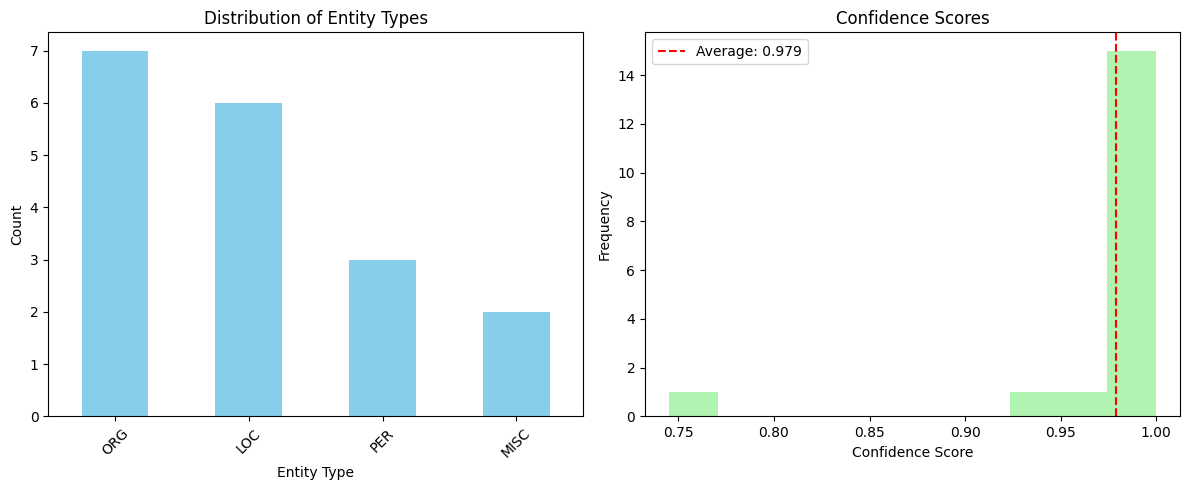


💡 Summary:
• Found 18 entities across 8 texts
• Average confidence: 0.979
• Most common entity type: ORG

✅ Named Entity Recognition completed!


In [10]:
# Rerun NER cell
# Named Entity Recognition (NER) - Simple and Clear
print("🏷️  NAMED ENTITY RECOGNITION")
print("=" * 35)

print("📦 Loading NER model...")
print("💡 This will identify people, places, organizations, and other entities in text")

# Simple NER setup with a reliable model
try:
    # Specify the torch_dtype to avoid the torch.load vulnerability issue
    ner_analyzer = pipeline(
        "ner",
        model="dbmdz/bert-large-cased-finetuned-conll03-english",
        aggregation_strategy="simple",
        device=-1,  # Use CPU for stability
        torch_dtype=torch.float32 # Added torch_dtype
    )
    print("✅ NER model loaded successfully!")
except Exception as e:
    print(f"⚠️  Could not load specified model due to: {e}")
    print("💡 Falling back to a simpler model.")
    ner_analyzer = pipeline("ner", aggregation_strategy="simple", device=-1)
    print("✅ Fallback NER model loaded successfully!")


# Clear example texts with diverse entities
ner_texts = [
    "Apple Inc. was founded by Steve Jobs in Cupertino, California.",
    "The meeting with Microsoft is scheduled for Tuesday in London.",
    "Barack Obama served as President of the United States.",
    "Google announced new AI research at their headquarters.",
    "The FIFA World Cup 2022 took place in Qatar.",
    "OpenAI released ChatGPT, revolutionizing AI conversations.",
    "Elon Musk founded SpaceX and Tesla in the United States.",
    "The European Union implemented new privacy regulations."
]

print("\nExtracting named entities from text:\n")

all_entities = []
for i, text in enumerate(ner_texts, 1):
    print(f"Text {i}: '{text}'")

    try:
        entities = ner_analyzer(text)

        if entities:
            print("  Entities found:")
            for entity in entities:
                entity_type = entity['entity_group']
                entity_text = entity['word']
                confidence = entity['score']

                all_entities.append({
                    'text': entity_text,
                    'type': entity_type,
                    'confidence': confidence
                })

                # Simple confidence indicator
                conf_indicator = "🔥" if confidence > 0.9 else "✅" if confidence > 0.7 else "🔶"
                print(f"    • {entity_text} → {entity_type} {conf_indicator} ({confidence:.3f})")
        else:
            print("    No entities found.")
        print()
    except Exception as e:
        print(f"⚠️  Could not analyze text '{text}' due to: {e}")
        print()


# Simple analysis and visualization
if all_entities:
    entity_df = pd.DataFrame(all_entities)

    print("📊 ENTITY ANALYSIS")
    print("=" * 20)

    # Count entity types
    entity_counts = entity_df['type'].value_counts()
    print("Entity types found:")
    for entity_type, count in entity_counts.items():
        avg_conf = entity_df[entity_df['type'] == entity_type]['confidence'].mean()
        print(f"  • {entity_type}: {count} occurrences (avg confidence: {avg_conf:.3f})")

    # Simple visualization
    plt.figure(figsize=(12, 5))

    # Plot 1: Entity type distribution
    plt.subplot(1, 2, 1)
    entity_counts.plot(kind='bar', color='skyblue')
    plt.title('Distribution of Entity Types')
    plt.xlabel('Entity Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Plot 2: Confidence distribution
    plt.subplot(1, 2, 2)
    plt.hist(entity_df['confidence'], bins=10, color='lightgreen', alpha=0.7)
    plt.title('Confidence Scores')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.axvline(entity_df['confidence'].mean(), color='red', linestyle='--',
                label=f'Average: {entity_df["confidence"].mean():.3f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\n💡 Summary:")
    print(f"• Found {len(all_entities)} entities across {len(ner_texts)} texts")
    print(f"• Average confidence: {entity_df['confidence'].mean():.3f}")
    print(f"• Most common entity type: {entity_counts.index[0]}")
else:
    print("No entities were found in the provided texts.")


print("\n✅ Named Entity Recognition completed!")